<a href="https://colab.research.google.com/github/dtabuena/Data_Explore/blob/main/DGC_Ratio_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [177]:
'''
Add Boot strap random sampling stats:
Randomly reclasify single label, E3-T1-17 -> E4-T1-17.
Calc prob observed ratio higher/lower than shuffled ratios.
'''


'\nAdd Boot strap random sampling stats:\nRandomly reclasify single label, E3-T1-17 -> E4-T1-17.\nCalc prob observed ratio higher/lower than shuffled ratios.\n'

In [178]:
!pip install openpyxl
!pip install XlsxWriter
!pip install pingouin
!pip install CMH
!pip install svgutils

from IPython.display import clear_output
import pandas as pd
import os
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

clear_output()

from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
import scipy
# from pandas.compat.numpy import np_array_datetime64_compat
from random import sample
from tqdm import tqdm
import os
import shutil
from google import colab


!wget 'https://www.dropbox.com/s/j0ts1hpt76xzvdq/arial.ttf'
mpl.font_manager.fontManager.addfont('/content/arial.ttf')

clear_output()

In [179]:

def get_files(link):
    my_drop_folder = 'my_drop_folder'
    zipped_file_path = "/content/"+my_drop_folder + ".zip"
    unzipped_file_path = "/content/"+my_drop_folder
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path
    file_list = [f for r,d,f in os.walk("/content/"+my_drop_folder )][0]
    return file_list

In [180]:
link = 'https://www.dropbox.com/sh/vnndh8qo9dkhyh3/AABc-bU5bXepR5PmBcQMvwrba?dl=0' # NEW sAHP
# link = 'https://www.dropbox.com/sh/e52vk7qbr4p0pfw/AACSiEAskL4ZSexlFN0L5S76a?dl=0' # OLD sAHP
file_list = get_files(link)
file_list = [f for f in file_list if 'param' in f]
_ = [print(f) for f in file_list]

Archive:  /content/my_drop_folder.zip
mapname:  conversion of  failed
replace /content/my_drop_folder/CA1 main parameters_Clean.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename:  extracting: /content/my_drop_folder/CA1 main parameters_Clean.xlsx  
 extracting: /content/my_drop_folder/CA3 parameters for PCA_Clean.xlsx  
 extracting: /content/my_drop_folder/DG Type I GC main parameters_Clean.xlsx  
 extracting: /content/my_drop_folder/DG Type II GC main parameters_Clean.xlsx  
CA3 parameters for PCA_Clean.xlsx
CA1 main parameters_Clean.xlsx
DG Type II GC main parameters_Clean.xlsx
DG Type I GC main parameters_Clean.xlsx


100%|██████████| 1000/1000 [00:15<00:00, 63.19it/s]


SCRAM  ['Geno']


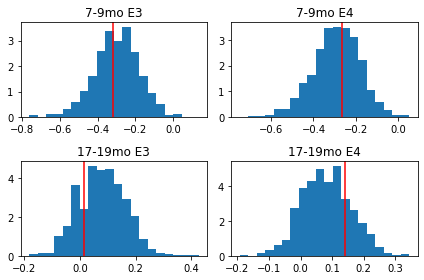

100%|██████████| 1000/1000 [00:15<00:00, 65.45it/s]


SCRAM  ['Age']


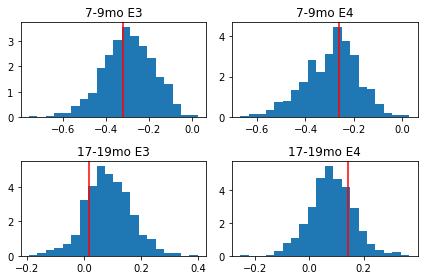

In [182]:
def make_df(file_list,type_list =['DG Type II', 'DG Type I']):
    cmh_df = pd.DataFrame(columns=['Geno','Age','Type'])
    counts = {}
    for f in file_list:
        if 'DG' in f:
            c_type = [t for t in type_list if t+' ' in f][0]
            my_df_dict,_ = read_data_file(f)
            for k,v in my_df_dict.items():
                if '19' in k: age = '17-19mo'
                else: age = '7-9mo'
                if 'E4' in k: e4_table.at[age,c_type]=v.shape[0]
                else: e3_table.at[age,c_type]=v.shape[0]

                a = np.array([[k.split(' ')[0], k.split(' ')[1], c_type]]*v.shape[0])
                # print(a)
                df2 = pd.DataFrame(data=a, columns=['Geno','Age','Type'])
                cmh_df = pd.concat( [cmh_df, df2],axis=0,join="outer",ignore_index=True)
                # cmh_df.append(df2, ignore_index=True)
    # cmh_df['c_id'] = np.arange(len(cmh_df.index))
    # cmh_df=cmh_df.reindex(index='c_id')
    return cmh_df


def read_data_file(xl_to_analyze):
    my_df_dict  = pd.read_excel('my_drop_folder/'+xl_to_analyze, engine='openpyxl',index_col=None,sheet_name=None)

    NEW_my_df_dict = {}
    for k in my_df_dict.keys():
        new_k = k
        if 'cre' in new_k:
            new_k = k.replace('Syn1-cre','/Syn1-Cre')
        NEW_my_df_dict[new_k] = my_df_dict[k]

    return NEW_my_df_dict, xl_to_analyze


def make_tables(cmh_df,type_list):
    e3_table = pd.DataFrame( [[0,0], [0,0]],index=['7-9mo','17-19mo'],columns=type_list)
    e4_table = pd.DataFrame( [[0,0], [0,0]],index=['7-9mo','17-19mo'],columns=type_list)
    

    for id in cmh_df.index:
        age =cmh_df.loc[id,'Age']
        geno = cmh_df.loc[id,'Geno']
        c_type = cmh_df.loc[id,'Type']
        if 'E4' in geno:
            e4_table.at[age,c_type]=e4_table.at[age,c_type]+1
        if 'E3' in geno:
            e3_table.at[age,c_type]=e3_table.at[age,c_type]+1

    rat_table = pd.DataFrame( [[0,0], [0,0]],index=['7-9mo','17-19mo'],columns=['E3','E4'],dtype=object)
    rat_table.at['7-9mo','E3'] =  np.array(e3_table.loc['7-9mo','DG Type I'] / ( e3_table.loc['7-9mo','DG Type II']  )) # + e3_table.loc['7-9mo','DG Type I']
    rat_table.at['7-9mo','E4'] = np.array(e4_table.loc['7-9mo','DG Type I'] / ( e4_table.loc['7-9mo','DG Type II'] )) # + e4_table.loc['7-9mo','DG Type I']
    rat_table.at['17-19mo','E3'] = np.array(e3_table.loc['17-19mo','DG Type I'] / ( e3_table.loc['17-19mo','DG Type II'] )) # + e3_table.loc['17-19mo','DG Type I']
    rat_table.at['17-19mo','E4'] = np.array(e4_table.loc['17-19mo','DG Type I'] / ( e4_table.loc['17-19mo','DG Type II'] )) # + e4_table.loc['17-19mo','DG Type I']
    
    for a in ['7-9mo','17-19mo']:
        for g in ['E3','E4']:
            rat_table.at[a,g] = np.log10(rat_table.loc[a,g])

    return e3_table, e4_table, rat_table


def col_scram(cmh_df,col_l):
    cmh_df_scram = cmh_df.copy()
    len_ = len(cmh_df_scram.index)
    for c in col_l:
        r_ind = np.random.choice(np.arange(len_), size=len_,replace=False)
        cmh_df_scram[c] = cmh_df_scram[c][r_ind].values

    return cmh_df_scram

def quantify(cmh_df,col_l,type_list):
    num_iter = 1000
    fig,axs=plt.subplots(2,2)
    axs = axs.flatten()
    _,_,og_rat_table = make_tables(cmh_df, type_list)
    scram_stack = og_rat_table.copy()
    # display(og_rat_table)
    for iter in tqdm( range(num_iter) ):
        cmh_df_scram = col_scram(cmh_df,['Geno'])
        e3_table, e4_table, rat_table = make_tables(cmh_df_scram, type_list)

        
        scram_stack.at['7-9mo','E3'] = np.concatenate( [np.array([scram_stack.at['7-9mo','E3']]).flatten(),
                                                        np.array([rat_table.loc['7-9mo','E3']])] )
        
        scram_stack.at['7-9mo','E4'] = np.concatenate( [np.array([scram_stack.at['7-9mo','E4']]).flatten(),
                                                        np.array([rat_table.loc['7-9mo','E4']])] )
        
        scram_stack.at['17-19mo','E3'] = np.concatenate( [np.array([scram_stack.at['17-19mo','E3']]).flatten(),
                                                        np.array([rat_table.loc['17-19mo','E3']])] )
        
        scram_stack.at['17-19mo','E4'] = np.concatenate( [np.array([scram_stack.at['17-19mo','E4']]).flatten(),
                                                        np.array([rat_table.loc['17-19mo','E4']])] )


    density = True
    cumulative= False
    print('SCRAM ', col_l )
    axs[0].hist(scram_stack.at['7-9mo','E3'],20,density=density,cumulative=cumulative)
    axs[0].axvline(og_rat_table.loc['7-9mo','E3'],color='r')
    axs[0].set_title('7-9mo E3')

    axs[1].hist(scram_stack.at['7-9mo','E4'],20,density=density,cumulative=cumulative)
    axs[1].axvline(og_rat_table.loc['7-9mo','E4'],color='r')
    axs[1].set_title('7-9mo E4')

    axs[2].hist(scram_stack.at['17-19mo','E3'],20,density=density,cumulative=cumulative)
    axs[2].axvline(og_rat_table.loc['17-19mo','E3'],color='r')
    axs[2].set_title('17-19mo E3')

    axs[3].hist(scram_stack.at['17-19mo','E4'],20,density=density,cumulative=cumulative)
    axs[3].axvline(og_rat_table.loc['17-19mo','E4'],color='r')
    axs[3].set_title('17-19mo E4')
    plt.tight_layout()
    plt.show()
    return None




cmh_df = make_df(file_list)
e3_table, e4_table, rat_table = make_tables(cmh_df, type_list)
col_l = ['Geno']
quantify(cmh_df,col_l,type_list)

col_l = ['Age']
quantify(cmh_df,col_l,type_list)

100%|██████████| 1000/1000 [00:22<00:00, 44.44it/s]


SCRAM  ['Geno', 'Age']


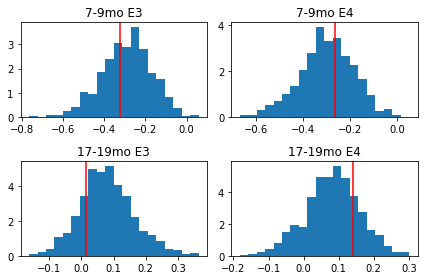

In [183]:

col_l = ['Geno','Age']
quantify(cmh_df,col_l,type_list)

,E3,E4
7-9mo,0.4782608695652174,0.5454545454545454
17-19mo,1.0357142857142858,1.3846153846153846


100%|██████████| 1000/1000 [00:16<00:00, 60.68it/s]


SCRAM  ['Type']


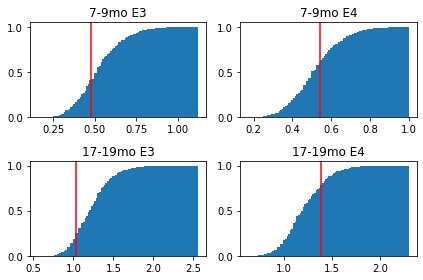

In [ ]:
col_l = ['Type']
quantify(cmh_df,col_l,type_list)

In [ ]:
_,_,og_rat_table = make_tables(cmh_df, type_list)
display(og_rat_table)

,E3,E4
7-9mo,0.323529,0.352941
17-19mo,0.508772,0.580645


In [ ]:
from cmh import CMH

# print(type_list)



##### DG TypeR ######
type_list =['DG Type II', 'DG Type I']
cmh_df = pd.DataFrame(columns=['Geno','Age','Type'])
counts = {}

e4_table =pd.DataFrame(columns=type_list,index=['7-9mo','17-19mo'])
e3_table = e4_table.copy()
for f in file_list:
    if 'DG' in f:
        c_type = [t for t in type_list if t+' ' in f][0]
        my_df_dict,_ = read_data_file(f)
        for k,v in my_df_dict.items():
            if '19' in k: age = '17-19mo'
            else: age = '7-9mo'
            if 'E4' in k: e4_table.at[age,c_type]=v.shape[0]
            else: e3_table.at[age,c_type]=v.shape[0]

            a = np.array([[k.split(' ')[0], k.split(' ')[1], c_type]]*v.shape[0])
            df2 = pd.DataFrame(data=a, columns=['Geno','Age','Type'])
            cmh_df = cmh_df.append(df2, ignore_index=True)

print('E3')
display(e3_table)

print('E4')
display(e4_table)

# result = CMH(cmh_df, 'Type', 'Age', stratifier='Geno')
# display(result)

result = CMH(cmh_df, 'Type', 'Age', stratifier='Geno')
display(result)
result = CMH(cmh_df, 'Type', 'Geno', stratifier='Age')
display(result)
result = CMH(cmh_df, 'Age', 'Geno', stratifier='Type')
display(result)

E3


<ipython-input-20-5794e2a02f25>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-20-5794e2a02f25>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-20-5794e2a02f25>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-20-5794e2a02f25>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-20-5794e2a02f25>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

,DG Type II,DG Type I
7-9mo,23,11
17-19mo,28,29


E4


,DG Type II,DG Type I
7-9mo,22,12
17-19mo,26,36


Cochran-Mantel-Haenszel Chi2 test

"Type" x "Age", stratified by "Geno"

Cochran-Mantel-Haenszel M^2 = 7.37318, dof = 1, p-value = 0.0066

Cochran-Mantel-Haenszel Chi2 test

"Type" x "Geno", stratified by "Age"

Cochran-Mantel-Haenszel M^2 = 0.61499, dof = 1, p-value = 0.4329

Cochran-Mantel-Haenszel Chi2 test

"Age" x "Geno", stratified by "Type"

Cochran-Mantel-Haenszel M^2 = 0.01265, dof = 1, p-value = 0.9105

In [ ]:

def get_files(link):
    my_drop_folder = 'my_drop_folder'
    zipped_file_path = "/content/"+my_drop_folder + ".zip"
    unzipped_file_path = "/content/"+my_drop_folder
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path
    file_list = [f for r,d,f in os.walk("/content/"+my_drop_folder )][0]
    return file_list

def read_data_file(xl_to_analyze):
    my_df_dict  = pd.read_excel('my_drop_folder/'+xl_to_analyze, engine='openpyxl',index_col=None,sheet_name=None)

    NEW_my_df_dict = {}
    for k in my_df_dict.keys():
        new_k = k
        if 'cre' in new_k:
            new_k = k.replace('Syn1-cre','/Syn1-Cre')
        NEW_my_df_dict[new_k] = my_df_dict[k]

    return NEW_my_df_dict, xl_to_analyze

def dict_to_df(my_df_dict,AP_cut=60):
    '''convert dict of categories into a DF'''
    for k in my_df_dict.keys():
        df = my_df_dict[k]
        df['type'] = k
    df_list = [my_df_dict[k] for k in my_df_dict.keys()]
    full_df = pd.concat(df_list,ignore_index=True)

    '''drop low AP amps'''
    for r in full_df.index:
        if full_df.loc[r,'AP amp'] <AP_cut:
            full_df.at[r,'AP amp'] = np.nan
    return full_df

def clean_data(labeling,full_df):

    numericals = [c for c in full_df.columns if c not in labeling ]

    full_df_norm = full_df.copy()
    mean_dict = {}
    sd_dict = {}

    if 'extras' not in full_df.columns:
        exclude_extras = False
        plot_extras = False

    for c in full_df_norm.columns:
        if c not in labeling:
            col_mean = np.mean(full_df_norm[c])
            col_sd = np.std(full_df_norm[c])
            mean_dict[c] = col_mean
            sd_dict[c] = col_sd
            full_df_norm[c] = (full_df_norm[c] - col_mean)/col_sd


    null_check = pd.isna(full_df_norm)
    incomplete =[]
    for r in full_df_norm.index:
        vals = np.array(null_check.loc[r,numericals])
        bad = any(vals)
        if bad:
            incomplete.append(r)


    complete = [c for c in  full_df_norm.index if c not in incomplete]
    full_df_no_null = full_df_norm.loc[complete].copy()


    if exclude_extras:
        is_extra = list(full_df_no_null['extra']==1)
        extra_ind = full_df_no_null.index[is_extra]
        full_df_no_null.drop( index =extra_ind, inplace=True)


    data_X = full_df_no_null[numericals].to_numpy()
    data_for_fit = data_X
    numericals = [n.replace('(1)', '') for n in numericals]
    return numericals, data_for_fit, full_df_no_null

def get_types(full_df_no_null):
    type_list = list(full_df_no_null['type'])
    uniq_types = list(set(type_list))
    young_types = [t for t in uniq_types if '-9' in t and 'Cre' not in t]
    young_types.sort()
    cre_types = [t for t in uniq_types if 'Cre' in t]
    cre_types.sort()
    old_types = [t for t in uniq_types if '-19' in t and 'Cre' not in t]
    old_types.sort()
    uniq_types = young_types + cre_types + old_types
    # print(uniq_types)
    num_t = len(uniq_types)
    type_num = [ uniq_types.index(t) for t in type_list]
    return type_num, num_t, uniq_types,type_list

def cluster_full(data_for_fit,xl_to_analyze,labels):
    random_state = 42
    if 'CA1' in xl_to_analyze:
        random_state = 47
    if 'Type I ' in xl_to_analyze:
        random_state = 43
    if 'Type II ' in xl_to_analyze:
        random_state = 42
    

    rheo_ind = [i for i in range(len(labels)) if 'Rheo' in labels[i]][0]

    # kmeans = KMeans(n_clusters=2, random_state=random_state).fit(data_for_fit)
    needs_flip = True
    while needs_flip:
        random_state+=1
        print('random_state',random_state)
        kmeans = KMeans(n_clusters=2, random_state=random_state).fit(data_for_fit)
        centers = kmeans.cluster_centers_.T
        needs_flip = np.diff(centers[rheo_ind])<0
        print(np.diff(centers[rheo_ind]))

    # centers = kmeans.cluster_centers_.T
    distances = kmeans.transform(data_for_fit)
    rel_centers = (centers.T - np.mean(centers.T,axis = 0)).T


    labels = kmeans.labels_ 
    rel_counts = [np.mean( l == labels ) for l in range(2)]
    new_cent_order = np.argsort(centers[:,0]).tolist()

    total_D = np.tile(np.sum(distances,axis=1),[2,1]).T
    closeness = np.log(total_D/distances)
    closeness = (closeness - np.mean(closeness,axis=0)) / (np.std(closeness,axis=0))  
    distances_norm = (distances - np.mean(distances,axis=0)) / (np.std(distances,axis=0))
    score = closeness[:,1] - closeness[:,0]

    packaged = {'features':numericals,
                'kmeans':kmeans,
                'centers':centers,
                'distances':distances,
                'rel_centers':rel_centers,
                'rel_counts':rel_counts,
                'total_D':total_D,
                'closeness':closeness,
                'distances_norm':distances_norm,
                'score':score,
                'data_for_fit':data_for_fit,
                'new_cent_order':new_cent_order
                }

    return packaged


def plot_summary(num_t,numericals,type_list,uniq_types,packaged,df_for_34_2W_anova,folder, clust_names = ['More Excitable', 'Less Excitable'],fig_opt = {'dpi': 300, 'format':'png','bbox_inches':'tight'}):
    # fig_opt = {'dpi': 300, 'format':'svg','bbox_inches':'tight'}
    # fontdict = {'family': 'arial','size':14}
    cmap = plt.cm.cool(np.linspace(0,1,2))*np.array([0.6]*3+[1])
    dark_cool = mpl.colors.ListedColormap(cmap)
    

    kmeans = packaged['kmeans']
    centers = packaged['centers']
    distances = packaged['distances']
    rel_centers = packaged['rel_centers']
    rel_counts = packaged['rel_counts']
    total_D = packaged['total_D']
    closeness = packaged['closeness']
    distances_norm = packaged['distances_norm']
    score = packaged['score']
    data_for_fit = packaged['data_for_fit']
    cell_type = packaged['cell_type']


    plt.rcParams.update({'font.size': 18, 'font.family': 'arial'})
    colors = plt.cm.viridis(np.linspace(0,1,num_t))
    alpha_1 = 1
    alpha_2 = .4
    colors = [[4/255, 51/255, 255/255, alpha_1], [4/255, 51/255, 255/255, alpha_2],
              [255/255, 38/255, 0/255, alpha_1], [255/255, 38/255, 0/255, alpha_2], 
            #   [1/255, 143/255, 0/255, alpha_1], [1/255, 143/255, 0/255, alpha_2]]
                [254/255, 224/255, 144/255, alpha_1], [254/255, 224/255, 144/255, alpha_2]]


    list_colors = [colors[i] for i in type_num ]
    color_dc={'apoE3-KI 7-9mo': colors[0],
                'apoE3-KI 17-19mo': colors[1],
                'apoE4-KI 7-9mo':colors[2],
                'apoE4-KI 17-19mo': colors[3],
                'fE4/Syn1-Cre+ 7-9mo': colors[4],
                'fE4/Syn1-Cre- 7-9mo': colors[5],}


    # color_dc={'apoE3-KI Type_I 7-9mo': colors[0][:-1]+[alpha_1],
    #           'apoE3-KI Type_II 7-9mo': colors[1][:-1]+[alpha_2],
    #           'apoE4-KI Type_I 7-9mo': colors[2][:-1]+[alpha_1],
    #           'apoE4-KI Type_II 7-9mo': colors[3][:-1]+[alpha_2],
    #           'apoE3-KI Type_I 17-19mo': colors[4][:-1]+[alpha_1],
    #           'apoE3-KI Type_II 17-19mo': colors[5][:-1]+[alpha_2],
    #           'apoE4-KI Type_I 17-19mo': colors[6][:-1]+[alpha_1],
    #           'apoE4-KI Type_II 17-19mo': colors[7][:-1]+[alpha_2],}



    '''### raw_data_map '''
    plt.rcParams.update({'font.size': 14,'font.family': 'arial'}) #14
    counts = [np.sum( [tt==t for tt in type_list]) for t in uniq_types ]
    fig_norm_vals, ax = plt.subplots(1,num_t,figsize = [16,4],gridspec_kw={'width_ratios': counts},constrained_layout=True)
    data_X_min = np.min(data_for_fit)
    data_X_max = np.max(data_for_fit)
    extrema = np.array([-1,1]) * np.max(np.abs([data_X_min,data_X_max]))
    data_X_min = extrema[0]
    data_X_max = extrema[1]

    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = colors[ti]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
        c = ax[ti].pcolor(data_for_fit.T[:,is_type], vmin=data_X_min*1.2, vmax=data_X_max*1.2)
        ax[ti].set_yticks(np.arange(len(numericals))+0.5)
        if ti ==0 : ax[ti].set_yticklabels(numericals,rotation=0)
        else:  ax[ti].get_yaxis().set_visible(False)
        ax[ti].set_xlabel('Cell (#)')
        ax[ti].title.set_text(t.replace(' ','\n'))
        start = min(is_type)+3 / len(is_type)
        stop = max(is_type)-3 / len(is_type)
    fig_norm_vals.suptitle(cell_type+ ' Normalized Parameters',y=1.05, fontsize=20)
    plt.tight_layout()
    plt.colorbar(c, ax=ax[ti],label='z-scored'+'\n'+'values')
    plt.show()

    plt.rcParams.update({'font.size': 14,'font.family': 'arial'}) #14


    ################# Centers 
    new_cent_order = np.argsort(centers[:,1]).tolist()[::-1]
    # fig_clust_pie, ax = plt.subplots(1,2,figsize = [12,5], gridspec_kw={'width_ratios': [2, 1]} )
    fig_centers, ax = plt.subplots(1,1,figsize = [4.5,4])
    ax.set_prop_cycle(color=[cmap[0], cmap[1]])
    ax.plot(centers[new_cent_order,:],'-o',linewidth=3)
    ax.legend(clust_names,loc='lower center',fontsize=12,frameon=False)
    sorted_numericals = [numericals[i] for i in new_cent_order]
    ax.set_xticks(np.arange(len(numericals)))
    ax.set_xticklabels(sorted_numericals,rotation=45,ha='right', rotation_mode='anchor',fontsize=14)
    ax.set_ylabel('z-scored'+' '+'values') 
    ax.axhline(0,color='k')
    ax.title.set_text(cell_type +' '+'Cluster Centers')
    plt.tight_layout()

    ################# Split Distance heat map
    counts = [np.sum( [tt==t for tt in type_list]) for t in uniq_types ]
    print(counts)
    b_dim = 2
    # fig_distances_split, ax = plt.subplots(1,num_t,figsize = [8,3],gridspec_kw={'width_ratios': counts},constrained_layout=True) ## OG
    fig_distances_split, ax = plt.subplots(1,num_t,figsize = [16,2],gridspec_kw={'width_ratios': counts},constrained_layout=True) ## NEw
    dist_min = np.min(distances_norm)
    dist_max = np.max(distances_norm)

    extrema = np.array([-1,1]) * np.max(np.abs([dist_min,dist_max]))
    dist_min = extrema[0]
    dist_max = extrema[1]

    plt.rcParams.update({'font.size': 14,'font.family': 'arial'}) #14
    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = colors[ti]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
        c = ax[ti].pcolor(distances_norm.T[:,is_type], vmin=dist_min*1.2, vmax=dist_max*1.2)
        ax[ti].set_yticks(np.arange(len(clust_names))+0.5)
        clust_names_nl = [c.replace(' ',' ') for c in clust_names]
        if ti ==0 : ax[ti].set_yticklabels(clust_names_nl,rotation=0)
        else:  ax[ti].get_yaxis().set_visible(False)        
        # ax[ti].title.set_text(t.replace(' ','\n'))
        # ax[ti].title.set_fontsize(16)
        # ax[ti].title.set_rotation(60)
        ax[ti].set_xlabel('Cell (#)')    
    fig_distances_split.tight_layout()
    fig_distances_split.colorbar(c, ax=ax[ti],label='z-scored'+'\n'+'distance')
    for ti in range(num_t):
        t = uniq_types[ti]
        ax[ti].text(0.5, 1, t.replace(' ','\n'),transform=ax[ti].transAxes,ha='center',rotation=0,va='bottom',fontsize=14)
    plt.show()
    # xxxxxxx

    ############# Combined Scatter
    fig_comb_scatter, ax = plt.subplots(1,figsize = [4,4])
    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = color_dc[t]
        print(t,t_colr)
        t_colr_edge = t_colr[:-1] + [alpha_1]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
        ax.scatter(distances_norm[is_type,0],distances_norm[is_type,1],color=t_colr, label=t,linewidths=1,edgecolors=t_colr_edge,s=80)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Dist. from '+clust_names[0]+' Center \n (z-scored)')
    ax.set_ylabel('Dist. from '+clust_names[1]+' Center \n (z-scored)')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='k')
    ax.text(0.98, 0.02, ''+clust_names[1],transform=ax.transAxes,ha='right',va='bottom',fontsize=12)
    ax.text(0.02, 0.98, ''+clust_names[0],transform=ax.transAxes,ha='left',va='top',fontsize=12)
    comb_xlim = ax.get_xlim()
    comb_ylim = ax.get_ylim()
    # print(comb_xlim)
    # print(comb_ylim)
    common_lim = np.array([-1,1]) * np.max(np.abs(list(comb_xlim)+list(comb_ylim)))
    common_lim= [np.min([comb_xlim[0],comb_ylim[0]]), np.max([comb_xlim[1],comb_ylim[1]]) ]
    # print(common_lim)
    ax.set_xlim(common_lim)
    ax.set_ylim(common_lim)

    #### separate Scatter #####
    b_dim = 3
    plt.rcParams.update({'font.size': 16, 'font.family': 'arial'})
    if 'CA3' in cell_type: fig_sep_scatter, axs = plt.subplots(1,num_t,figsize = [num_t*b_dim,b_dim*1.2])
    else: fig_sep_scatter, axs = plt.subplots(2,int(num_t/2),figsize = [int(num_t/2)*b_dim,b_dim*2*1.2]) #  [int(num_t/2)*b_dim,b_dim*2]
    axs = axs.T.flatten()
    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = color_dc[t]
        t_colr_edge = t_colr[:-1] + [alpha_1]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
        axs[ti].scatter(distances_norm[is_type,0],distances_norm[is_type,1],color=t_colr, label=t,linewidths=1,edgecolors=t_colr_edge,s=36)
        axs[ti].plot([0, 1], [0, 1], transform=axs[ti].transAxes,color=[0,0,0,1])
        axs[ti].title.set_text(t.replace(' ','\n'))
        axs[ti].set_xlim(common_lim)
        axs[ti].set_ylim(common_lim)


        axs[ti].set_xlabel(clust_names[0]+' Dist.',fontsize=14)
        axs[ti].set_ylabel(clust_names[1]+' Dist.',fontsize=14)
        axs[ti].text(0.98, 0.02, ''+clust_names[1],transform=axs[ti].transAxes,ha='right',va='bottom',fontsize=14)
        axs[ti].text(0.02, 0.98, ''+clust_names[0],transform=axs[ti].transAxes,ha='left',va='top',fontsize=14)

    x=distances_norm[is_type,0]
    y=distances_norm[is_type,1]
    for i in range(len(x)):
        plt.plot([x[i], x[i]], [y[i], x[i]], 'k:')

    plt.rcParams.update({'font.size': 18, 'font.family': 'arial'})
    plt.tight_layout()


    # #### separate PDFS #####
    # fig_sep_hist, axs = plt.subplots(2,int(num_t/2),figsize = [int(num_t/2)*5,5])
    # axs = axs.T.flatten()
    # for ti in range(num_t):
    #     t = uniq_types[ti]
    #     t_colr = colors[ti]
    #     t_colr_edge = colors[  int(np.ceil((ti+1)/2)-1)*2 ]
    #     is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]

    #     axs[ti].hist(score[is_type],14,color=t_colr,histtype='bar',density=True,range=(-3.25,3.25),edgecolor=t_colr_edge,linewidth=1)
    #     axs[ti].title.set_text(t)
    #     axs[ti].axvline(0, color='k') # vertical
    #     axs[ti].set_ylim(0,0.65)
    #     axs[ti].set_ylabel('PDF')
    #     fs = 14
    #     axs[ti].text(.95, .85, clust_names[1],transform=axs[ti].transAxes,ha='right',fontsize = fs)
    #     axs[ti].text(.05, .85, clust_names[0],transform=axs[ti].transAxes,ha='left',fontsize = fs)

    # axs[3].set_xlabel('Residuals')
    # plt.tight_layout()



    ########  ''' Violins of Residual Plots '''
    fig_violin_residuals, ax = plt.subplots(1,figsize=[3*int(num_t/2),4])
    comb_list = list(set(df_for_34_2W_anova['combination']))

    young_types = [t for t in comb_list if '-9' in t and 'Cre' not in t]
    young_types.sort()
    cre_types = [t for t in comb_list if 'Cre' in t]
    cre_types.sort()
    old_types = [t for t in comb_list if '-19' in t and 'Cre' not in t]
    old_types.sort()
    comb_list = young_types + cre_types + old_types

    sns_dict={}
    print(comb_list)
    for ti in range(len(comb_list)):
        type_i = comb_list[ti]
        match_type = df_for_34_2W_anova['combination']==type_i
        y_vals = list(np.array(df_for_34_2W_anova[match_type]['T1_Score']))
        x_vals = np.ones_like(y_vals)*ti + int(np.floor(ti/2))
        pos = list(np.ones_like(y_vals)*ti)
        t_colr = colors[ti]    
        t_colr = color_dc[type_i]
        # t_colr_edge = colors[  int(np.ceil((ti+1)/2)-1)*2 ]
        # sns_dict[type_i] = y_vals
        sns_dict[type_i] =y_vals

    print(sns_dict.keys())
    sns_df =  pd.DataFrame.from_dict(sns_dict, orient='index').T
    display(sns_df.head())
   
    colors_sns = [color_dc[t] for t in sns_df.columns]
    # colors_sns = [color_dc[k] for k in color_dc.keys()]
    colors_sns = [ list(np.array(c[:-1]) + (1 - np.array(c[:-1]))* (1-c[-1])) + list(c[-1:]) for c in  colors_sns]

    sns.swarmplot(ax=ax,data=sns_df,color='k', label=t,linewidths=1,edgecolors='k',size=7)
    sns.violinplot(ax=ax,data=sns_df,palette=colors_sns, 
                   scale ='area', label=t,linewidths=1,inner='quartile',edgecolors='k')
    FS = 16
    ax.text(.05, .98, clust_names[1],transform=ax.transAxes,ha='left',va='top',fontsize = FS)
    ax.text(.05, .02, clust_names[0],transform=ax.transAxes,ha='left',fontsize = FS)
    ax.set_ylabel('Residual Value')
    ax.set_ylim(-7.5,9.5)
    ax.axhline(0,color='k')
    ax_labels = sns_df.columns
    ax.set_xticks(ticks=range(len(ax_labels)))
    ax_labels_r = [c.replace(' ','\n') for c in ax_labels]
    ax_labels_r = [c.replace('\nsyn',' syn') for c in ax_labels_r]
    ax_labels_r = [c.split('\n')[0]  for c in ax_labels_r]
    ax_labels_r = [c.replace('-Cre', '\nCre') for c in ax_labels_r]
    # ax_labels_r = ['\n'+ax_labels_r[i] if i%2 == 0 else ax_labels_r[i] for i in range(len(ax_labels_r)) ]
    ax.set_xticklabels(ax_labels_r,rotation=0,ha='center', rotation_mode='anchor',fontsize=FS)
    ax.title.set_text(cell_type+' Cluster Membership')
    
    div_x = np.sum( ['7-9' in l for l in ax_labels])-0.5
    segment_x = [div_x, div_x]
    segment_y = ax.get_ylim()*np.array([1.75,1])
    print('segments',segment_x,segment_y)
    ll = plt.plot(segment_x,segment_y,':k') # returns a sequence of line objects
    ll[0].set_clip_on(False)
    plt.text(div_x/2-0.25, segment_y[0]-0, '7-9mo', fontsize=FS+2,ha='center',va='bottom')
    plt.text(div_x+1, segment_y[0]-0, '17-19mo', fontsize=FS+2,ha='center',va='bottom')

    plt.show()

    fig_norm_vals.savefig(f'{folder}/Normalized_Vals_split.'+fig_opt['format'],**fig_opt)
    fig_violin_residuals.savefig(f'{folder}/fig_violin_residuals.'+fig_opt['format'],**fig_opt)    
    fig_distances_split.savefig(f'{folder}/fig_distances_split.'+fig_opt['format'],**fig_opt)    
    # fig_centers.savefig(f'{folder}/centers.'+fig_opt['format'],**fig_opt)
    # fig_pie.savefig(f'{folder}/pie.'+fig_opt['format'],**fig_opt)
    fig_sep_scatter.savefig(f'{folder}/GenoType_dist_Separate.'+fig_opt['format'],**fig_opt)
    fig_comb_scatter.savefig(f'{folder}/GenoType_dist.'+fig_opt['format'],**fig_opt)
    # fig_sep_hist.savefig(f'{folder}/GenoType_Histos.'+fig_opt['format'],**fig_opt)
    return None    


def do_stats(type_list,score):
    is_E3 = ['E3' in t for t in type_list ]
    is_9mo = ['-19' not in t for t in type_list ]
    age_list = ['7-9' if b else '17-19' for b in is_9mo]
    genotype = ['apoE3-KI' if b else 'apoE4-KI' for b in is_E3]
    is_crePos = ['cre+' in t for t in type_list ]
    is_creNeg = ['cre-' in t for t in type_list ]
    not_cree = [not any( [is_crePos[i], is_creNeg[i]] ) for i in range(len(is_crePos))]
    e34_genotype = [genotype[i] for i in range(len(not_cree)) if not_cree[i]]
    e34_score = [score[i] for i in range(len(not_cree)) if not_cree[i]]
    e34_age = [str(age_list[i])+'mo' for i in range(len(not_cree)) if not_cree[i]]
    genotype_list_str = [t.replace(' 7-9mo', '').replace(' 17-19mo', '') for t in type_list]
    age_list_str = [str(a)+'mo' for a in age_list]
    
    df_for_34_2W_anova =  pd.DataFrame({'genotype': genotype_list_str,  'Age': age_list_str,'T1_Score': score})


    ANOVA2_results = pg.anova(dv='T1_Score', between=['genotype', 'Age'], data=df_for_34_2W_anova, detailed=True)
    display(ANOVA2_results)

    ANOVA2_results.to_csv(f'{folder}/2W_results Age-Geno.csv')
    df_for_34_2W_anova['combination'] = df_for_34_2W_anova.genotype + " " + df_for_34_2W_anova.Age
    m_comp = pairwise_tukeyhsd(endog=df_for_34_2W_anova['T1_Score'], groups=df_for_34_2W_anova['combination'], alpha=0.05)
    tukey_data = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
    tukey_data = tukey_data.sort_values('p-adj',ascending=True)
    display(tukey_data)

    tukey_data.to_csv(f'{folder}/pairwise Age-Genotype.csv')
    df_for_34_2W_anova.to_csv(f'{folder}/Scores.csv')
    return df_for_34_2W_anova, tukey_data




def cross_val(data_for_fit,numericals,new_cent_order,folder,k=2,
              num_iter = 1000,SubSampleFrac = .8,cell_type='',fig_opt = {'dpi': 300, 'format':'svg','bbox_inches':'tight'},ds_iter=10):
    center_list = []
    label_list = []
    sub_sample_ind_list = []
    full_label_list = []
    pred_all = True
    sorted_numericals = [numericals[i] for i in new_cent_order]
    plt.rcParams.update({'font.size': 18, 'font.family': 'arial'})
    cmap = plt.cm.cool(np.linspace(0,1,k))*np.array([0.6]*3+[1])
    dark_cool = mpl.colors.ListedColormap(cmap)

    for ni in tqdm( range(num_iter) ):
        sub_sample_ind = []
        for t in uniq_types:
            t_inds = [i for i in range(len(type_list)) if t in type_list[i]]
            # print(t_inds)
            sub_sample_ind.extend( sample(t_inds, int(len(t_inds)*SubSampleFrac) ) )
        kmeans_iter = KMeans(n_clusters=k, random_state=42).fit(data_for_fit[sub_sample_ind][:,new_cent_order])
        centers_iter = kmeans_iter.cluster_centers_.T
        centers_iter = centers_iter - np.mean(centers_iter,axis=0)
        labels_iter = kmeans_iter.labels_
        if pred_all:
            labels_iter = kmeans_iter.predict(data_for_fit)

        if ni>0:
            corco = np.corrcoef(centers_iter.T,center_list[0].T)
            corco = corco[0:k,k:]
            ind = np.argmax(corco,axis=0) 
            centers_iter = centers_iter[:,ind]
            labels_iter = [ind[l] for l in labels_iter]
        
        if not pred_all:
            full_label_iter = np.empty((data_for_fit.shape[0],))
            full_label_iter[:] = np.nan
            full_label_iter[sub_sample_ind] = labels_iter
        else:
            full_label_iter = labels_iter

        center_list.append(centers_iter)
        label_list.append(labels_iter)
        sub_sample_ind_list.append(sub_sample_ind_list)
        full_label_list.append(full_label_iter)
   
    center_stack = np.stack(center_list)
    mean_center = np.mean(center_stack,0)
    nintey_p_center = np.percentile(center_stack, [.5, 99.5], axis=0)

    ####### PLOT CENTERS
    plt.rcParams.update({'font.size': 18,'font.family': 'arial'}) #14
    fig_cv_cent, ax = plt.subplots(1,figsize = (9,5))
    handle_list = []
    if k == 2:
        clust_names = [ 'More Excitable', 'Less Excitable'] 
        rheo_index_in_center = [i for i in range(len(numericals)) if 'Rheo' in numericals[i]]
        rheo_dif = np.diff(mean_center[rheo_index_in_center,:])[0]
        if rheo_dif<0: clust_names=clust_names[::-1]

    for ki in range(k):
        if k==2: ax.plot(mean_center[:,ki].T,'-o',color=cmap[ki],linewidth=3,label = clust_names[ki])
        else: ax.plot(mean_center[:,ki].T,'-o',color=cmap[ki],linewidth=3)
        ax.plot(nintey_p_center[0,:,ki].T,':',color=cmap[ki],linewidth=2)
        ax.plot(nintey_p_center[1,:,ki].T,':',color=cmap[ki],linewidth=2)

    ax.set_xticks(np.arange(len(numericals)))
    ax.set_xticklabels(sorted_numericals,rotation=45,ha='right', rotation_mode='anchor') # ,fontsize=14
    ax.axhline(0, color='k')   
        
    if k == 2: ax.legend(loc='lower center',fontsize=14,frameon=False)
    ax.set_ylabel('z-scored'+' '+'values') 


    full_label_stack = np.stack(full_label_list)

    pseudo_truth = scipy.stats.mode(full_label_stack,axis=0, nan_policy='omit')[0]
    is_match = (full_label_stack == pseudo_truth)*1. # convert to float so can accept nans
    is_match[np.isnan(full_label_stack)]=np.nan
    consistency_iter = np.nanmean(is_match, axis = 1)
    mean_consistency_iter = np.nanmean(consistency_iter)
    std_consistency_iter = np.nanstd(consistency_iter)
    consistency_cell = np.nanmean(is_match, axis = 0)
    mean_consistency_cell = np.nanmean(consistency_cell)
    sd_consistency_cell = np.nanstd(consistency_cell)
    consistency_report = 'label consistency: ' + str(round(mean_consistency_cell*100,1)) + '% +- ' + str(round(sd_consistency_cell*100,2)) + ' (chance: ' + str(round(1/k*100,1))+')'
    ax.title.set_text(cell_type)

    plt.tight_layout()
    plt.show()
    fig_cv_cent.savefig(f'{folder}/CrossVal_Data k={k} Centers.'+fig_opt['format'],**fig_opt)

    plt.rcParams.update({'font.size': 18, 'font.family': 'arial'})
    fig_cv_prob, ax = plt.subplots(2,2,figsize=[6,4.5], gridspec_kw={'height_ratios': [3, 1],'width_ratios': [4, 1.1]}  )
    ax  = ax.T.flatten()

    iters_ds = np.arange(0,num_iter,ds_iter) +1
    cell_ids = np.arange(0,full_label_stack.shape[0]) +1
    pcol = ax[0].pcolorfast(iters_ds,cell_ids,full_label_stack[::ds_iter,:],cmap=dark_cool)
    # pcol.set_edgecolor('face')

    ax[0].set_xlabel('Cell (#)')
    ax[0].set_ylabel('Iteration (#)')
    ax[0].xaxis.set_label_position('top') 
    ax[0].xaxis.tick_top()

    ax[1].scatter(np.arange(len(consistency_cell)),consistency_cell*100,color='k',s=2)
    ax[1].axhline(1/k*100,color='k',linestyle=':')
    ax[1].set_ylabel('Cell\nConsistency (%)')
    ax[1].set_ylim((0,102))
    ax[1].set_xlim((0,is_match.shape[1]))
    ax[1].set_xlabel('Cell (#)')

    ax[2].scatter(consistency_iter*100,np.arange(num_iter),color='k',s=2)
    ax[2].axvline(1/k*100,color='k',linestyle=':')
    ax[2].set_xlabel('Iteration\nConsistency (%)')
    ax[2].set_xlim((102,0))
    ax[2].set_ylim((0,num_iter))
    ax[2].yaxis.tick_right()
    ax[2].xaxis.set_label_position('top') 
    ax[2].xaxis.tick_top()

    # fig.delaxes(ax[3])
    ax[3].errorbar(mean_consistency_iter*100, mean_consistency_cell*100,
                   yerr=sd_consistency_cell*100, xerr=std_consistency_iter*100,color='k',capsize=3)
    ax[3].axvline(1/k*100,color='k',linestyle=':')
    ax[3].axhline(1/k*100,color='k',linestyle=':')
    ax[3].set_xlim((100,0))
    ax[3].set_ylim((0,100))
    ax[3].yaxis.tick_right()

    fig_cv_prob.suptitle(f'k = {k} clusters', y=1.15,fontsize=22,)#  y=1.075
    plt.show()

    fig_cv_prob.savefig(f'{folder}/CrossVal_Data k={k} Labeling.'+fig_opt['format'],**fig_opt)
    return None


def save_dl(folder):
    root_list = []
    f_list = []
 
    fold_name = folder
    fold_name = fold_name.replace(' ','_')
    zip_name= fold_name+'.zip'

    print(folder)
    !zip -r $zip_name $folder
    colab.files.download(zip_name)
    return None








In [ ]:
link = 'https://www.dropbox.com/sh/vnndh8qo9dkhyh3/AABc-bU5bXepR5PmBcQMvwrba?dl=0' # NEW sAHP
# link = 'https://www.dropbox.com/sh/e52vk7qbr4p0pfw/AACSiEAskL4ZSexlFN0L5S76a?dl=0' # OLD sAHP
file_list = get_files(link)
file_list = [f for f in file_list if 'param' in f]
_ = [print(f) for f in file_list]


--2023-03-17 23:09:56--  https://www.dropbox.com/sh/vnndh8qo9dkhyh3/AABc-bU5bXepR5PmBcQMvwrba?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/vnndh8qo9dkhyh3/AABc-bU5bXepR5PmBcQMvwrba [following]
--2023-03-17 23:09:57--  https://www.dropbox.com/sh/raw/vnndh8qo9dkhyh3/AABc-bU5bXepR5PmBcQMvwrba
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc61865436f78e5fef73e37668e.dl.dropboxusercontent.com/zip_download_get/Bb36p8bnAdIX4I8S3R4KKV0QNy4LF99jIG0ZF7M_RTsCAekeA3GfBTabpfGDdS-KoPcdbhiZUZDgxX3l66QwZhSG77XUyu1iWlhr3P-2CsY2Jw# [following]
--2023-03-17 23:09:57--  https://ucc61865436f78e5fef73e37668e.dl.dropboxusercontent.com/zip_download_get/Bb36p8bnAdIX4I8S3R4KKV0QNy4LF99jIG0ZF7M_RTsCAekeA3GfBTabpfGDdS-KoPcdbhiZUZDgxX3l66QwZhSG77

In [ ]:

from cmh import CMH

# print(type_list)



##### DG TypeR ######
type_list =['DG Type II', 'DG Type I']
cmh_df = pd.DataFrame(columns=['Geno','Age','Type'])
counts = {}

e4_table =pd.DataFrame(columns=type_list,index=['7-9mo','17-19mo'])
e3_table = e4_table.copy()
for f in file_list:
    if 'DG' in f:
        c_type = [t for t in type_list if t+' ' in f][0]
        my_df_dict,_ = read_data_file(f)
        for k,v in my_df_dict.items():
            if '19' in k: age = '17-19mo'
            else: age = '7-9mo'
            if 'E4' in k: e4_table.at[age,c_type]=v.shape[0]
            else: e3_table.at[age,c_type]=v.shape[0]

            a = np.array([[k.split(' ')[0], k.split(' ')[1], c_type]]*v.shape[0])
            df2 = pd.DataFrame(data=a, columns=['Geno','Age','Type'])
            cmh_df = cmh_df.append(df2, ignore_index=True)

print('E3')
display(e3_table)

print('E4')
display(e4_table)

# result = CMH(cmh_df, 'Type', 'Age', stratifier='Geno')
# display(result)

result = CMH(cmh_df, 'Type', 'Age', stratifier='Geno')
display(result)
result = CMH(cmh_df, 'Type', 'Geno', stratifier='Age')
display(result)
result = CMH(cmh_df, 'Age', 'Geno', stratifier='Type')
display(result)

E3


<ipython-input-85-5794e2a02f25>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-85-5794e2a02f25>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-85-5794e2a02f25>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-85-5794e2a02f25>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-85-5794e2a02f25>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

,DG Type II,DG Type I
7-9mo,23,11
17-19mo,28,29


E4


,DG Type II,DG Type I
7-9mo,22,12
17-19mo,26,36


Cochran-Mantel-Haenszel Chi2 test

"Type" x "Age", stratified by "Geno"

Cochran-Mantel-Haenszel M^2 = 7.37318, dof = 1, p-value = 0.0066

Cochran-Mantel-Haenszel Chi2 test

"Type" x "Geno", stratified by "Age"

Cochran-Mantel-Haenszel M^2 = 0.61499, dof = 1, p-value = 0.4329

Cochran-Mantel-Haenszel Chi2 test

"Age" x "Geno", stratified by "Type"

Cochran-Mantel-Haenszel M^2 = 0.01265, dof = 1, p-value = 0.9105

In [ ]:
##### DG TypeR ######
type_list =['DG Type II', 'DG Type I']
cmh_df = pd.DataFrame(columns=['Geno','Age','Type'])
counts = {}

e4_table =pd.DataFrame(columns=type_list,index=['7-9mo','17-19mo'])
e3_table = e4_table.copy()
for f in file_list:
    if 'DG' in f:
        c_type = [t for t in type_list if t+' ' in f][0]
        my_df_dict,_ = read_data_file(f)
        for k,v in my_df_dict.items():
            if '19' in k: age = '17-19mo'
            else: age = '7-9mo'
            if 'E4' in k: e4_table.at[age,c_type]=v.shape[0]
            else: e3_table.at[age,c_type]=v.shape[0]

            a = np.array([[k.split(' ')[0], k.split(' ')[1], c_type]]*v.shape[0])
            df2 = pd.DataFrame(data=a, columns=['Geno','Age','Type'])
            cmh_df = cmh_df.append(df2, ignore_index=True)

print('E3')
display(e3_table)

print('E4')
display(e4_table)

# result = CMH(cmh_df, 'Type', 'Age', stratifier='Geno')
# display(result)



old_4 = [i for i in range(len(cmh_df['Age'])) if '17' in cmh_df['Age'][i] and 'E4' in cmh_df['Geno'][i]]
young_4 = [i for i in range(len(cmh_df['Age'])) if '17' not in cmh_df['Age'][i] and 'E4' in cmh_df['Geno'][i]]

old_3 = [i for i in range(len(cmh_df['Age'])) if '17' in cmh_df['Age'][i] and 'E3' in cmh_df['Geno'][i]]
young_3 = [i for i in range(len(cmh_df['Age'])) if '17' not in cmh_df['Age'][i] and 'E3' in cmh_df['Geno'][i]]


print(len(old_4))
print(len(young_4))
print(len(old_3))
print(len(young_3))

import random
add_young_4 = random.sample( young_4,len(old_4)-len(young_4))
add_young_3 = random.sample( young_3,len(old_4)-len(young_3))
add_old_3 = random.sample( old_3,len(old_4)-len(old_3))


for i in add_young_4:
    cmh_df = cmh_df.append(cmh_df.loc[i,:],  ignore_index=False)
for i in add_young_3:
    cmh_df = cmh_df.append(cmh_df.loc[i,:],  ignore_index=False)
for i in add_old_3:
    cmh_df = cmh_df.append(cmh_df.loc[i,:],  ignore_index=False)
clear_output()
cmh_df.reset_index()
display(cmh_df)
# 
new_ind = np.arange(len(cmh_df.index))
cmh_df['id'] = new_ind
cmh_df = cmh_df.set_index('id')

clear_output()

old_4 = [i for i in range(len(cmh_df['Age'])) if '17' in cmh_df['Age'][i] and 'E4' in cmh_df['Geno'][i]]
young_4 = [i for i in range(len(cmh_df['Age'])) if '17' not in cmh_df['Age'][i] and 'E4' in cmh_df['Geno'][i]]

old_3 = [i for i in range(len(cmh_df['Age'])) if '17' in cmh_df['Age'][i] and 'E3' in cmh_df['Geno'][i]]
young_3 = [i for i in range(len(cmh_df['Age'])) if '17' not in cmh_df['Age'][i] and 'E3' in cmh_df['Geno'][i]]

# # display(cmh_df)
print(len(old_4))
print(len(young_4))
print(len(old_3))
print(len(young_3))

# print('E3')
# display(e3_table)

# print('E4')
# display(e4_table)



62
62
62
62


Cochran-Mantel-Haenszel Chi2 test

"Type" x "Age", stratified by "Geno"

Cochran-Mantel-Haenszel M^2 = 9.35658, dof = 1, p-value = 0.0022

Cochran-Mantel-Haenszel Chi2 test

"Type" x "Geno", stratified by "Age"

Cochran-Mantel-Haenszel M^2 = 0.60641, dof = 1, p-value = 0.4361

Cochran-Mantel-Haenszel Chi2 test

"Age" x "Geno", stratified by "Type"

Cochran-Mantel-Haenszel M^2 = 0.02306, dof = 1, p-value = 0.8793

In [ ]:
##### DG TypeR ######
type_list =['DG Type II', 'DG Type I']
cmh_df = pd.DataFrame(columns=['Geno','Age','Type'])
counts = {}

e4_table =pd.DataFrame(columns=type_list,index=['7-9mo','17-19mo'])
e3_table = e4_table.copy()
for f in file_list:
    if 'DG' in f:
        c_type = [t for t in type_list if t+' ' in f][0]
        my_df_dict,_ = read_data_file(f)
        for k,v in my_df_dict.items():
            if '19' in k: age = '17-19mo'
            else: age = '7-9mo'
            if 'E4' in k: e4_table.at[age,c_type]=v.shape[0]
            else: e3_table.at[age,c_type]=v.shape[0]

            a = np.array([[k.split(' ')[0], k.split(' ')[1], c_type]]*v.shape[0])
            df2 = pd.DataFrame(data=a, columns=['Geno','Age','Type'])
            cmh_df = cmh_df.append(df2, ignore_index=True)

print('E3')
display(e3_table)

print('E4')
display(e4_table)


old_4 = [i for i in range(len(cmh_df['Age'])) if '17' in cmh_df['Age'][i] and 'E4' in cmh_df['Geno'][i]]
young_4 = [i for i in range(len(cmh_df['Age'])) if '17' not in cmh_df['Age'][i] and 'E4' in cmh_df['Geno'][i]]

old_3 = [i for i in range(len(cmh_df['Age'])) if '17' in cmh_df['Age'][i] and 'E3' in cmh_df['Geno'][i]]
young_3 = [i for i in range(len(cmh_df['Age'])) if '17' not in cmh_df['Age'][i] and 'E3' in cmh_df['Geno'][i]]


print(len(old_4))
print(len(young_4))
print(len(old_3))
print(len(young_3))

keep_old_e3 = random.sample(old_3,34)
keep_old_e4 = random.sample(old_4,34)

keeps = young_3 + young_4 + keep_old_e3 + keep_old_e4

cmh_df = cmh_df.loc[keeps,:]
result = CMH(cmh_df, 'Type', 'Age', stratifier='Geno')
display(result)

E3


<ipython-input-83-546f941fe7bf>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-83-546f941fe7bf>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-83-546f941fe7bf>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-83-546f941fe7bf>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-83-546f941fe7bf>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

,DG Type II,DG Type I
7-9mo,23,11
17-19mo,28,29


E4


,DG Type II,DG Type I
7-9mo,22,12
17-19mo,26,36


62
34
57
34


Cochran-Mantel-Haenszel Chi2 test

"Type" x "Age", stratified by "Geno"

Cochran-Mantel-Haenszel M^2 = 7.48342, dof = 1, p-value = 0.0062